In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import random, shuffle

from scipy.integrate import simps
import pandas as pd
import sys
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns

sys.path.append("..")
from utils.load_las_data import normalize_z_with_minz_in_a_radius

from config import args
from utils.load_las_data import *
from utils.useful_functions import *
import os
import numpy as np; np. set_printoptions(suppress=True);  # display values without scientific notation
import pandas as pd
from laspy.file import File
from sklearn.neighbors import NearestNeighbors
import warnings
import random

Arguments were imported in PROD mode


In [2]:
def load_and_clean_single_las(las_filename):
    """Load a LAD file into a np.array, convert coordinates to meters, clean a few anomalies in plots."""
    # Parse LAS files
    las = File(las_filename, mode="r")
    x_las = las.X / 100  # we divide by 100 as all the values in las are in cm
    y_las = las.Y / 100
    z_las = las.Z / 100
    r = las.Red
    g = las.Green
    b = las.Blue
    nir = las.nir
    intensity = las.intensity
    return_num = las.return_num
    num_returns = las.num_returns
    points_nparray = np.asarray(
        [x_las, y_las, z_las, r, g, b, nir, intensity, return_num, num_returns]
    ).T

    # There is a file with 2 points 60m above others (maybe birds), we delete these points
    if las_filename.endswith("Releve_Lidar_F70.las"):
        points_nparray = points_nparray[points_nparray[:, 2] < 640]
    # We do the same for the intensity
    if las_filename.endswith("POINT_OBS8.las"):
        points_nparray = points_nparray[points_nparray[:, -2] < 32768]
    if las_filename.endswith("Releve_Lidar_F39.las"):
        points_nparray = points_nparray[points_nparray[:, -2] < 20000]

    # get the center of a rectangle bounding the points
    xy_centers = [
        (x_las.max() - x_las.min()) / 2.0,
        (y_las.max() - y_las.min()) / 2.0,
    ]
    return points_nparray, xy_centers


def load_my_norm_data(args, subset=[]):

    # We open las files and create a training dataset
    nparray_clouds_dict = {}  # dict to store numpy array with each plot separately
    xy_centers_dict = (
        {}
    )  # we keep track of plots means to reverse the normalisation in the future

    # We iterate through las files and transform them to np array
    las_filenames = get_files_of_type_in_folder(args.las_placettes_folder_path, ".las")
    if subset:
        las_filenames = [l for l in las_filenames if any(b in l for b in subset) ]
    all_points_nparray = np.empty((0, len(args.input_feats)))
    for las_filename in las_filenames:
        # Parse LAS files
        points_nparray, xy_centers = load_and_clean_single_las(las_filename)
        points_nparray = pre_transform(
            points_nparray, args
        )
        all_points_nparray = np.append(all_points_nparray, points_nparray, axis=0)
        plot_name = get_filename_no_extension(las_filename)
        nparray_clouds_dict[plot_name] = points_nparray
        xy_centers_dict[plot_name] = xy_centers

    return all_points_nparray, nparray_clouds_dict, xy_centers_dict


def select_my_clouds(plots_of_interest = []):
    # F49 = nparray_clouds_dict["Releve_Lidar_F49"][:,:3]
    # F68 = nparray_clouds_dict["Releve_Lidar_F68"][:,:3]  # Vm everywhere
    # OBS_2021_6 = nparray_clouds_dict["2021_POINT_OBS6"][:,:3]  # "hyper flag en termes de MNT"
    # F20 = nparray_clouds_dict["Releve_Lidar_F20"][:,:3]  # "hyper flag en termes de MNT"
    if not plots_of_interest:
        plots_of_interest = [
            "Releve_Lidar_F68",
            "Releve_Lidar_F69",
            "2021_POINT_OBS9",  # grass 100%, high slope: 0-3m to 0-0.4cm slope with 1.5
            "Releve_Lidar_F49",  # loads of high vegetation. Ok with 1.5m
            "Releve_Lidar_F68",  # dense bushes. Ok with 1.5 : adds contrast.
            "2021_POINT_OBS6",  # 75% grass (subestimation of model). might add contrats linked to grass
            "Releve_Lidar_F20",  # 75% grass, 25% mid veg. ok,
            "2021_POINT_OBS59",
        ]
    # focus on medium veg
    plots_of_interest = plots_of_interest + []
    selection = {
        key: value
        for key, value in nparray_clouds_dict.items()
        if key in plots_of_interest
    }
    return selection
def view_distribution(params, all_z):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x = np.linspace(0, 2, 100)
    plt.hist(all_z, bins=50, range=(0, 2), density=True, histtype='stepfilled', alpha=0.2)
    plt.plot(
        x, params["phi"] * gamma.pdf(x, params["a_g"], 0, params["scale_g"]), "r-", lw=1, label="gamma1"
    )
    if "phi_2" in params:
        plt.plot(
            x, params["phi_2"] * gamma.pdf(x, params["a_v"], 0, params["scale_v"]), "k-", lw=1, label="gamma2"
        )
    plt.tight_layout()
    axes = plt.gca()
    axes.set_ylim([0, 1.1])
    plt.show(block=True)

# Subselection

In [3]:
all_points_nparray, nparray_clouds_dict, xy_centers_dict = load_my_norm_data(args)

In [4]:
from KDEpy import FFTKDE

def get_all_z_for_selection(nparray_clouds_dict, subset):
    print(len(subset))
    selection = select_my_clouds(plots_of_interest=subset)
    all_points_selection = np.empty((0, len(args.input_feats)))
    for key in selection:
        all_points_selection = np.append(all_points_selection, selection[key], axis=0)
    all_z = all_points_selection[:, 2]
    return all_z

In [5]:
# SELECT VB PLOTS
df = pd.read_csv(args.gt_file_path)
df = df[df["COUV_INTER"]<=10]
subset_Vb = df.Name.values.tolist()
z_all_Vb = get_all_z_for_selection(nparray_clouds_dict, subset_Vb)

# SELECT VM PLOTS
df_Vb_Vm = pd.read_csv(args.gt_file_path)
df_Vb_Vm = df_Vb_Vm[df_Vb_Vm["COUV_INTER"]>=75]
subset_Vb_Vm = df_Vb_Vm.Name.values.tolist()
z_all_Vb_Vm = get_all_z_for_selection(nparray_clouds_dict, subset_Vb_Vm)

# SELECT VH PLOTS
df_Vh = pd.read_csv(args.gt_file_path)
df_Vh = df_Vh[df_Vh["COUV_INTER"]<=25]
df_Vh = df_Vh[df_Vh["COUV_HAUTE"]>=75]
subset_Vh = df_Vh.Name.values.tolist()
z_all_Vh = get_all_z_for_selection(nparray_clouds_dict, subset_Vh)

100
26
32


In [6]:
means_Vb = df[["COUV_BASSE","COUV_INTER","COUV_HAUTE"]].mean()
sum_Vb = means_Vb.sum().round(2)
print(sum_Vb)

means_Vb_Vm = df_Vb_Vm[["COUV_BASSE","COUV_INTER","COUV_HAUTE"]].mean()
sum_Vb_Vm = means_Vb_Vm.sum().round(2)
print(sum_Vb_Vm)

means_Vh = df_Vh[["COUV_BASSE","COUV_INTER","COUV_HAUTE"]].mean()
sum_Vh = means_Vh.sum().round(2)
print(sum_Vh)

105.24
182.62
169.31


In [7]:
# Ratio of what would be the amount of Vm points if all plots had Vm = 100% / in the second selection.
# OIf we ignored trees, this would make the final diff kde corresponds to a density *if Vm was 100%*.
# N_ratio_to_Vm = len(subset_Vb) / (
#     len(subset_Vb_Vm) * (df_Vb_Vm["COUV_INTER"].mean() / 100)
# )
# print(f"N_ratio_to_Vm : {N_ratio_to_Vm}")

# N_ratio_to_Vh = len(subset_Vb) / (
#     len(subset_Vh) * (df_Vh["COUV_HAUTE"].mean() / 100)
# )
# print(f"N_ratio_to_Vh : {N_ratio_to_Vh}")


Vm_to_Vb_ratio = 2 * (1 / (df_Vb_Vm["COUV_INTER"].mean() / 100))  # 1 Vm = 1m height ~ 2Vb !
print(f"Vm_to_Vb_ratio : {Vm_to_Vb_ratio}")

Vh_to_Vb_ratio = (1 / (df_Vb_Vm["COUV_HAUTE"].mean() / 100)) 
print(f"Vh_to_Vb_ratio : {Vh_to_Vb_ratio}")

Vh_to_Vm_ratio = df_Vb_Vm["COUV_HAUTE"].mean() / 100/ (df_Vb_Vm["COUV_INTER"].mean() / 100)
print(f"Vh_to_Vm_ratio : {Vh_to_Vm_ratio}")

Vm_to_Vb_ratio : 2.5935162094763093
Vh_to_Vb_ratio : 1.7038007863695939
Vh_to_Vm_ratio : 0.7610972568578553


Fit the KDE and normalize them to have a globally coherent scale

In [53]:
from scipy.interpolate import interp1d

# Vb KDE
kde_Vb = FFTKDE(bw=0.1).fit(np.concatenate([-z_all_Vb, z_all_Vb]))
X, y_Vb = kde_Vb.evaluate(2**10)
f_Vb = interp1d(X, y_Vb, kind="linear", assume_sorted=False)

# Vm KDE
z_all_Vm_sym = np.concatenate([-z_all_Vb_Vm, z_all_Vb_Vm])
z_all_Vm_sym = np.sort(z_all_Vm_sym)
w_m = np.exp(-f_Vb(z_all_Vm_sym))
w_m[z_all_Vm_sym>1.5] = w_m[z_all_Vm_sym>1.5] * np.exp(1.5-z_all_Vm_sym[z_all_Vm_sym>1.5])
kde_Vb_Vm = FFTKDE(bw=0.1).fit(z_all_Vm_sym, w_m)
y_Vb_Vm = kde_Vb_Vm.evaluate(X)
y_Vb_Vm = y_Vb_Vm * Vm_to_Vb_ratio
f_Vb_Vm = interp1d(X, y_Vb_Vm, kind="linear", assume_sorted=False)

# Vh KDE
z_all_Vh_sym = np.concatenate([-z_all_Vh, z_all_Vh])
z_all_Vh_sym = np.sort(z_all_Vh_sym)
w_h = np.exp(-(f_Vb_Vm(z_all_Vh_sym) + f_Vb(z_all_Vh_sym))/2)
loc = np.abs(z_all_Vh_sym)<1.5
w_h[loc] = w_h[loc] * w_h[loc] * np.log(w_h[loc]/1.5)
kde_Vh = FFTKDE(bw=0.5).fit(z_all_Vh_sym, w_h)
y_Vh = kde_Vh.evaluate(X)
y_Vh = y_Vh * Vh_to_Vb_ratio
f_Vh = interp1d(X, y_Vh, kind="linear", assume_sorted=False)

Plot all the relevant KDE and thier differences

<IPython.core.display.Javascript object>


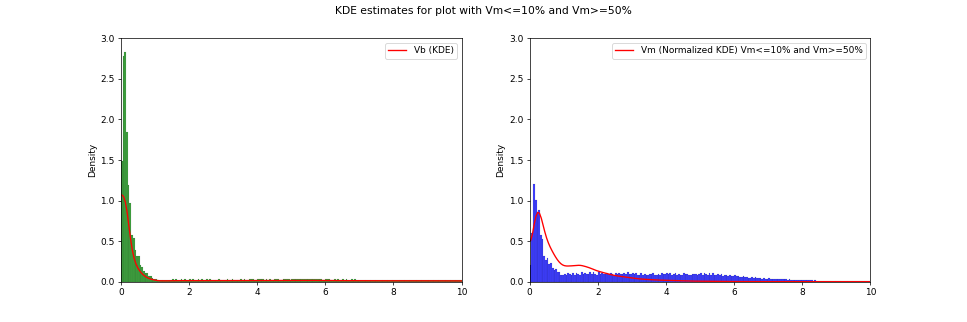

<IPython.core.display.Javascript object>


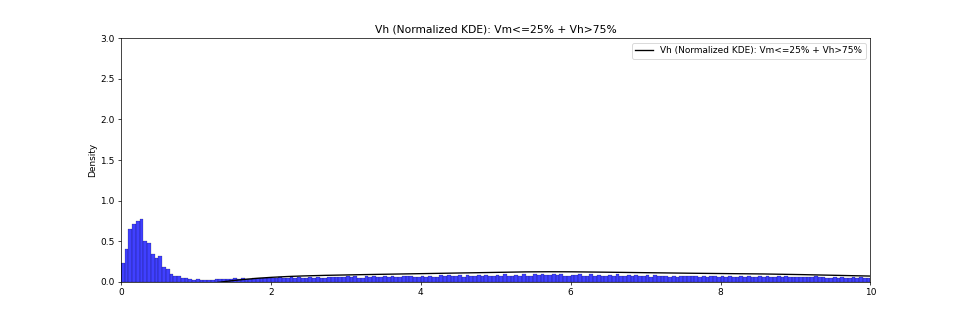

<IPython.core.display.Javascript object>


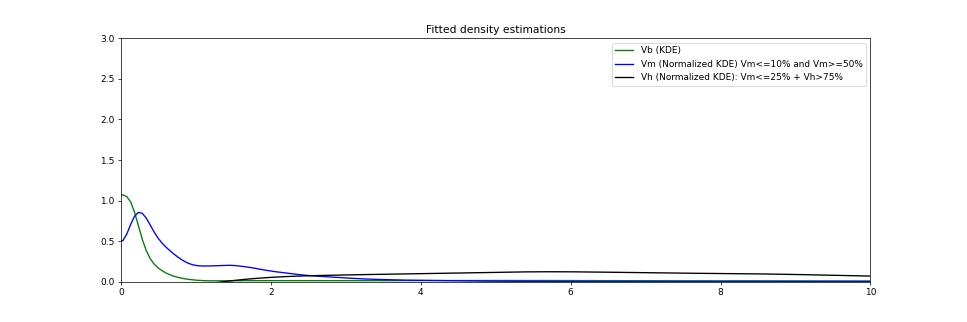

In [59]:
%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=np.array([3, 1]) * 5)

fig.suptitle("KDE estimates for plot with Vm<=10% and Vm>=50%")
sns.histplot(z_all_Vb, ax=ax1, stat="density", binwidth=0.05, color="green")
ax1.plot(X, y_Vb, label="Vb (KDE)", color="r")
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 3])
ax1.legend()

sns.histplot(z_all_Vb_Vm, ax=ax2, stat="density", binwidth=0.05, color="blue")
ax2.plot(X, y_Vb_Vm, label="Vm (Normalized KDE) Vm<=10% and Vm>=50%", color="r")
ax2.set_xlim([0, 10])
ax2.set_ylim([0, 3])
ax2.legend()

fig, ax3 = plt.subplots(1, 1, figsize=np.array([3, 1]) * 5)

sns.histplot(z_all_Vh, ax=ax3, stat="density", binwidth=0.05, color="blue")
ax3.set_title("Vh (Normalized KDE): Vm<=25% + Vh>75%")
ax3.plot(X, y_Vh, label="Vh (Normalized KDE): Vm<=25% + Vh>75%", color="black")
ax3.set_xlim([0, 10])
ax3.set_ylim([0, 3])
ax3.legend()

fig, (ax4) = plt.subplots(1, 1, figsize=np.array([3, 1]) * 5)

# sns.histplot(z_all_Vb, ax=ax4, stat="density", binwidth=0.05, color="green", label="Vb")
ax4.set_title("Fitted density estimations")
ax4.plot(X, y_Vb, label="Vb (KDE)", color="green")
ax4.plot(X, y_Vb_Vm, label="Vm (Normalized KDE) Vm<=10% and Vm>=50%", color="blue")
ax4.plot(X, y_Vh, label="Vh (Normalized KDE): Vm<=25% + Vh>75%", color="black")
ax4.set_xlim([0, 10])
ax4.set_ylim([0, 3])
ax4.legend()

<IPython.core.display.Javascript object>


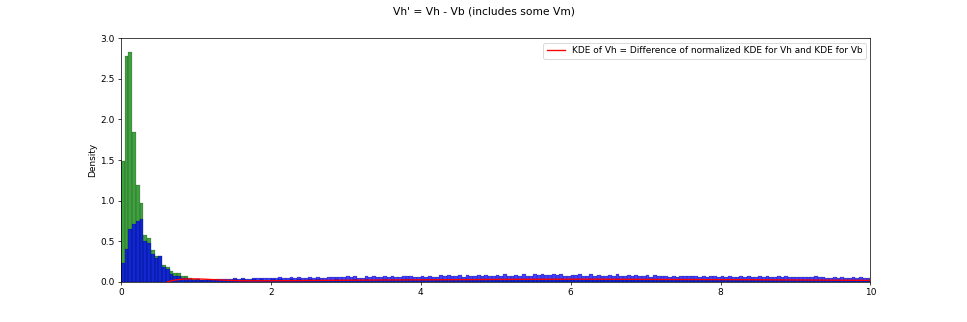

<IPython.core.display.Javascript object>


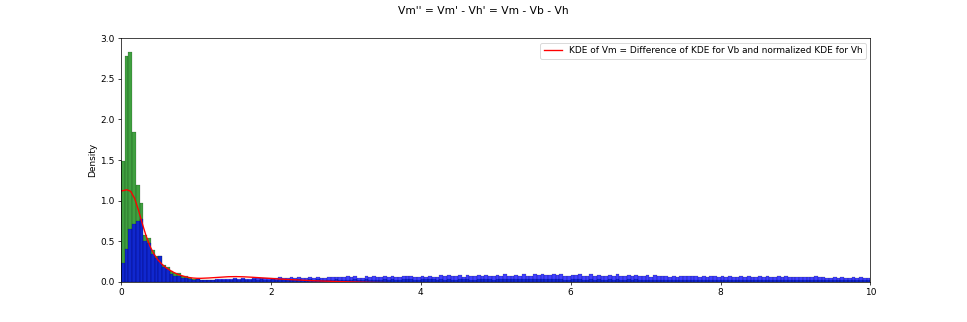

In [36]:
fig, (ax3) = plt.subplots(1, 1, figsize=np.array([3, 1]) * 5)
fig.suptitle("Vh' = Vh - Vb (includes some Vm)")
sns.histplot(z_all_Vb, ax=ax3, stat="density", binwidth=0.05, color="green")
sns.histplot(z_all_Vh, ax=ax3, stat="density", binwidth=0.05, color="blue")
ax3.plot(
    X,
    y_Vh - y_Vb,
    label="KDE of Vh = Difference of normalized KDE for Vh and KDE for Vb",
    color="r",
)
ax3.set_xlim([0, 10])
ax3.set_ylim([0, 3])
ax3.legend()

fig, (ax4) = plt.subplots(1, 1, figsize=np.array([3, 1]) * 5)
fig.suptitle("Vm'' = Vm' - Vh' = Vm - Vb - Vh")
sns.histplot(z_all_Vb, ax=ax4, stat="density", binwidth=0.05, color="green")
sns.histplot(z_all_Vh, ax=ax4, stat="density", binwidth=0.05, color="blue")
ax4.plot(
    X,
    y_Vb_Vm + y_Vb - y_Vh,
    label="KDE of Vm = Difference of KDE for Vb and normalized KDE for Vh",
    color="r",
)
ax4.set_xlim([0, 10])
ax4.set_ylim([0, 3])
ax4.legend()